In [1]:
import random
import numpy as np
from matplotlib import pyplot as plt
import cv2
import plotly.express as px
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

2023-04-23 06:49:59.668810: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-23 06:50:01.049029: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def preprocess_image(image_path, target_size):
    image = load_img(image_path, target_size=target_size, color_mode="grayscale")
    image_array = img_to_array(image)
    image_array = image_array / 255.0
    return image_array

In [3]:
INPUT_SHAPE = (224, 224, 1)
sample_image_paths = ['/home/smbh/bc/data/raw/2.jpeg', '/home/smbh/bc/data/raw/3.jpeg', '/home/smbh/bc/data/raw/2.jpeg', '/home/smbh/bc/data/raw/3.jpeg']
# Preprocess and organize the images into suitable format
sample_images = [preprocess_image(path, target_size=INPUT_SHAPE[:2]) for path in sample_image_paths]
sample_images = np.array(sample_images)
# Define the ground truth labels for your sample images (binary labels)
sample_labels = np.array([1, 0, 1, 0])
print(sample_images.shape)
print(sample_labels.shape)

(4, 224, 224, 1)
(4,)


In [4]:
def create_branch(input_shape):
    input_layer = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(input_layer)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(256, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    return input_layer, x

# Create the 4 branches
input1, branch1 = create_branch(INPUT_SHAPE)
input2, branch2 = create_branch(INPUT_SHAPE)
input3, branch3 = create_branch(INPUT_SHAPE)
input4, branch4 = create_branch(INPUT_SHAPE)

# Concatenate the output vectors from the 4 branches
concatenated = layers.Concatenate()([branch1, branch2, branch3, branch4])

# Add another Dense layer
hidden = layers.Dense(128, activation='relu')(concatenated)

# Add the output layer for binary classification
output = layers.Dense(1, activation='sigmoid')(hidden)

# Create the model
model = Model(inputs=[input1, input2, input3, input4], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

2023-04-23 06:50:02.815750: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-23 06:50:02.816367: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-23 06:50:02.826723: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                            

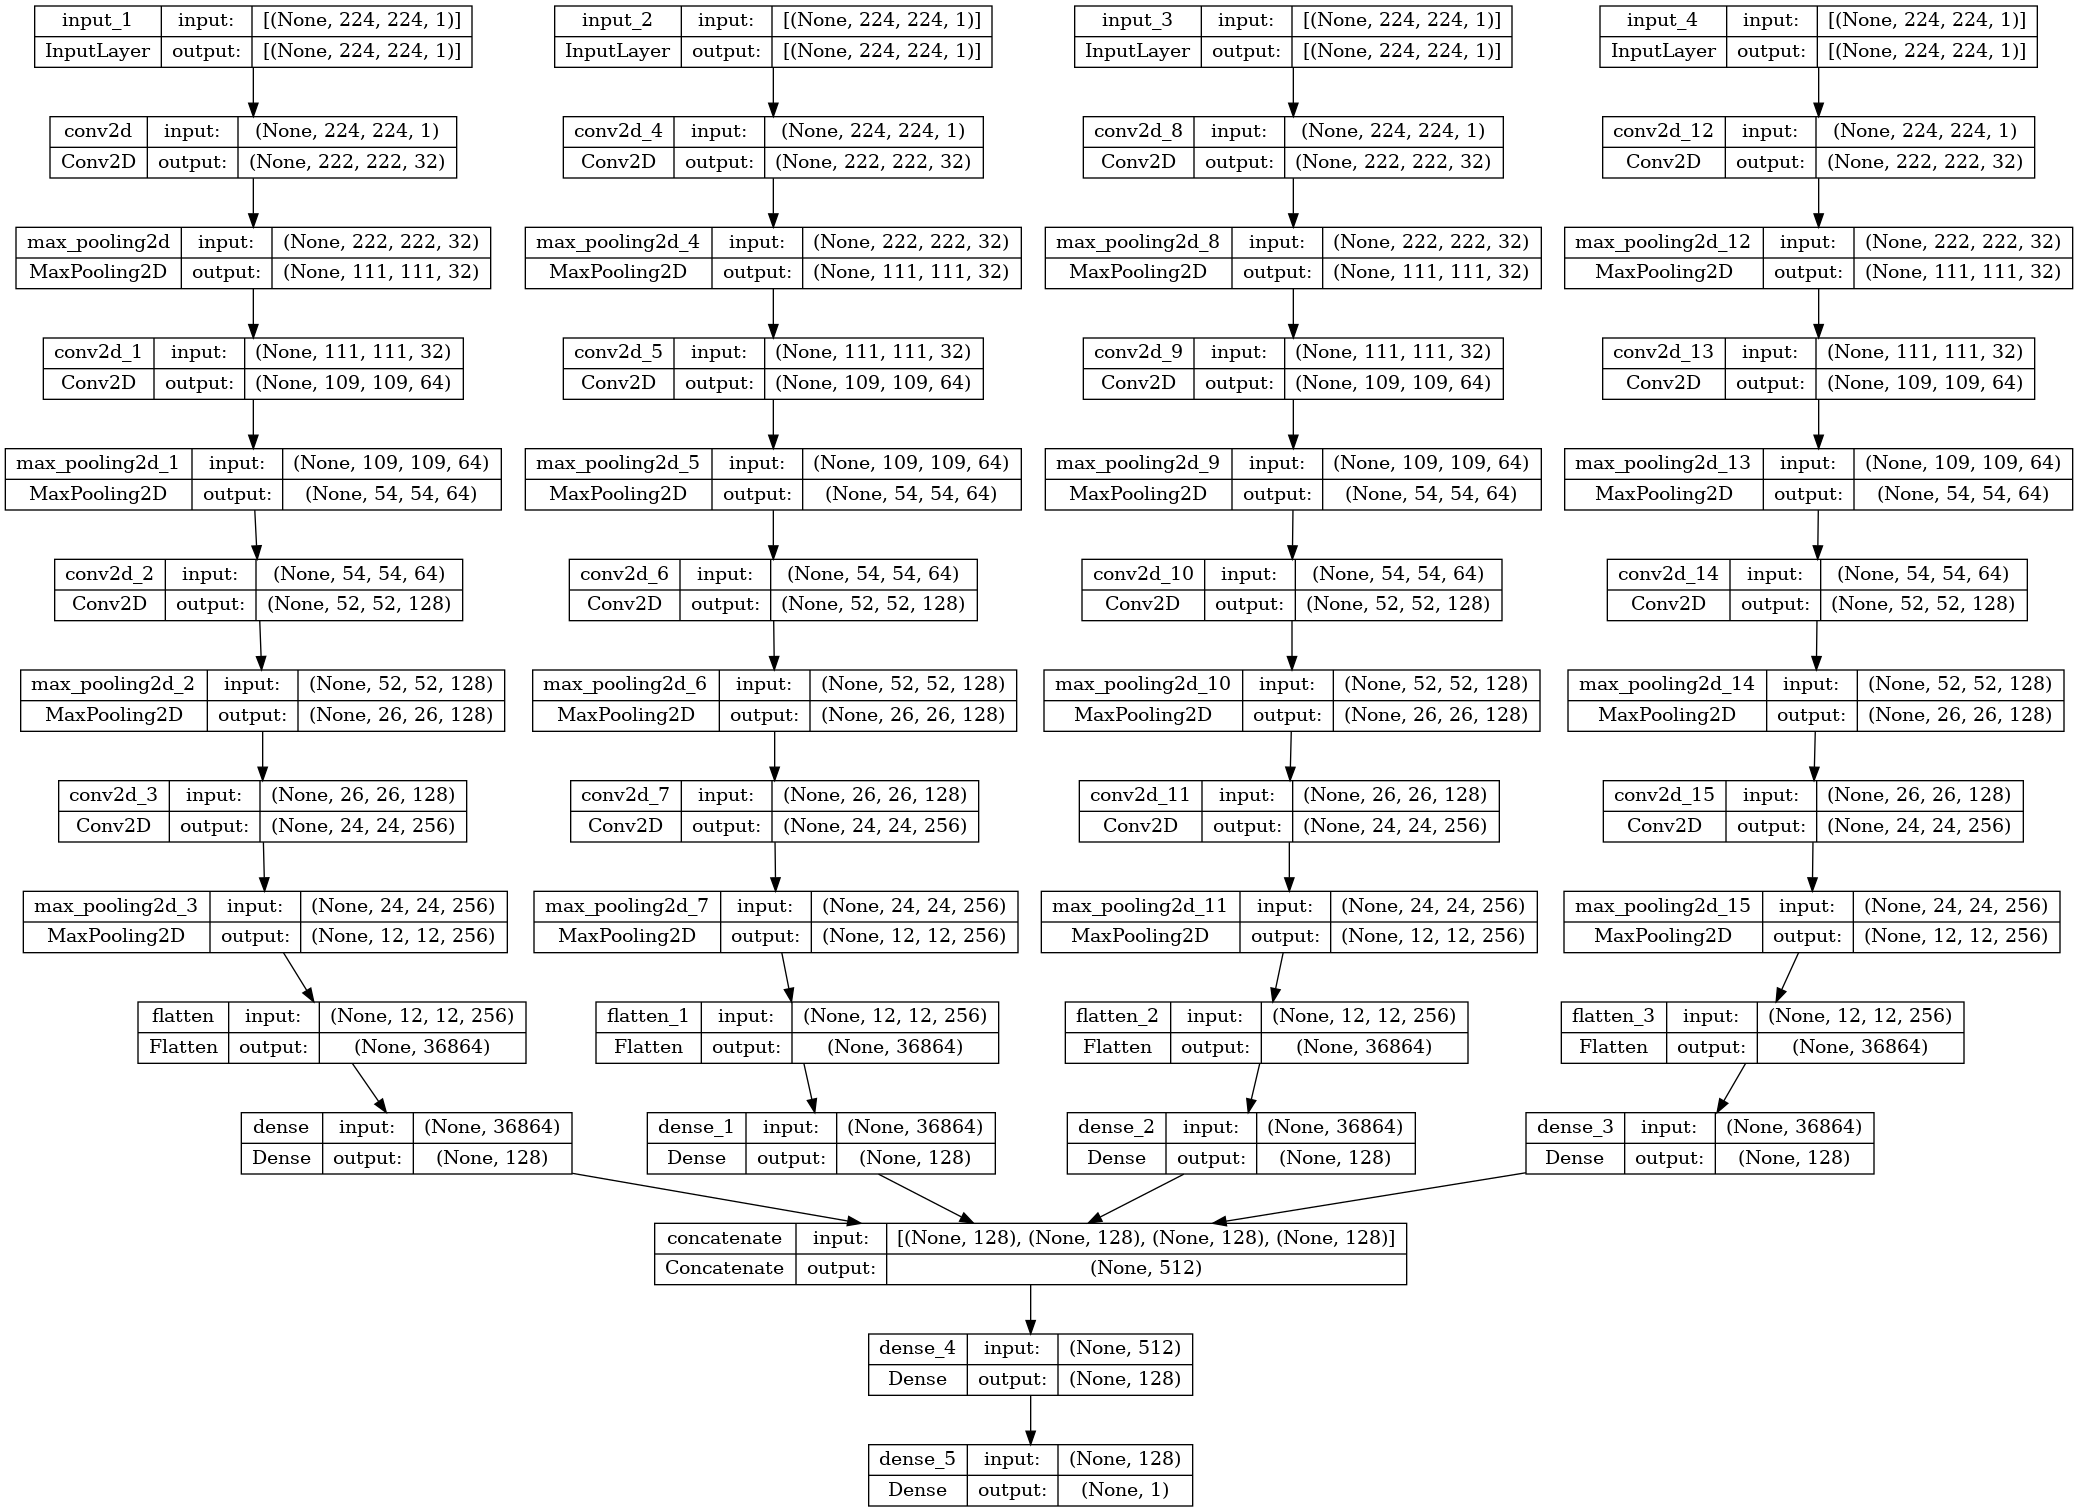

In [5]:
# plot model
tf.keras.utils.plot_model(model, show_shapes=True)

In [6]:
# Train the model
model.fit([sample_images, sample_images, sample_images, sample_images], sample_labels, epochs=1, batch_size=4)

Epoch 1/10


2023-04-23 06:50:16.338519: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 18.00MiB (rounded to 18874368)requested by op Fill
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-23 06:50:16.338623: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-23 06:50:16.338663: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 49, Chunks in use: 49. 12.2KiB allocated for chunks. 12.2KiB in use in bin. 4.6KiB client-requested in use in bin.
2023-04-23 06:50:16.338673: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 22, Chunks in use: 22. 11.0KiB allocated for chunks. 11.0KiB in use in bin. 11.0KiB client-requested in use in bin.
2023-04-23 06:50:16.338680: I tensorflow/tsl/framework/bfc

ResourceExhaustedError: in user code:

    File "/home/smbh/.venvs/bc/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/smbh/.venvs/bc/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/smbh/.venvs/bc/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/smbh/.venvs/bc/lib/python3.9/site-packages/keras/engine/training.py", line 1054, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/smbh/.venvs/bc/lib/python3.9/site-packages/keras/optimizers/optimizer.py", line 543, in minimize
        self.apply_gradients(grads_and_vars)
    File "/home/smbh/.venvs/bc/lib/python3.9/site-packages/keras/optimizers/optimizer.py", line 1174, in apply_gradients
        return super().apply_gradients(grads_and_vars, name=name)
    File "/home/smbh/.venvs/bc/lib/python3.9/site-packages/keras/optimizers/optimizer.py", line 637, in apply_gradients
        self.build(trainable_variables)
    File "/home/smbh/.venvs/bc/lib/python3.9/site-packages/keras/optimizers/adam.py", line 139, in build
        self.add_variable_from_reference(
    File "/home/smbh/.venvs/bc/lib/python3.9/site-packages/keras/optimizers/optimizer.py", line 1106, in add_variable_from_reference
        return super().add_variable_from_reference(
    File "/home/smbh/.venvs/bc/lib/python3.9/site-packages/keras/optimizers/optimizer.py", line 507, in add_variable_from_reference
        initial_value = tf.zeros(

    ResourceExhaustedError: {{function_node __wrapped__Fill_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[36864,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Fill]
